## Visualisasi Awal Data: Scatterplot

Visualisasi scatterplot antara variabel **Jumlah Murid SMA** dan **PDRB Harga Konstan** dari dataset yang telah dibersihkan untuk memahami distribusi awal dari data sebelum diklasterisasi:


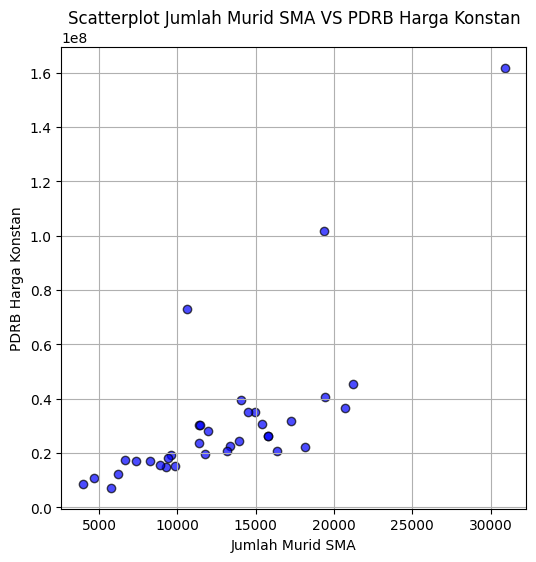

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dengan skala asli
data_clean = pd.read_csv('../../Dataset/data_cleaned.csv')

# Mengambil kolom yang akan digunakan untuk klasterisasi
X_original = data_clean[['Jumlah_Murid_SMA', 'PDRB_harga_konstan']] 

plt.figure(figsize=(6,6))
plt.scatter(X_original['Jumlah_Murid_SMA'], X_original['PDRB_harga_konstan'], 
            c='blue', edgecolor='k', alpha=0.7)
plt.title('Scatterplot Jumlah Murid SMA VS PDRB Harga Konstan')
plt.xlabel('Jumlah Murid SMA')
plt.ylabel('PDRB Harga Konstan')
plt.grid(True)
plt.show()


## Dendrogram dan Evaluasi Model Hierarchical Clustering

Dendrogram untuk menentukan jumlah klaster optimal pada metode Hierarchical Clustering menggunakan metode linkage *Ward*. Garis threshold digunakan untuk memotong dendrogram dan menentukan jumlah klaster (dalam hal ini 3 klaster). Setelah label klaster ditambahkan ke data, model dievaluasi menggunakan metrik **Silhouette Score** dan **Davies-Bouldin Index** untuk mengukur kualitas hasil klasterisasi.


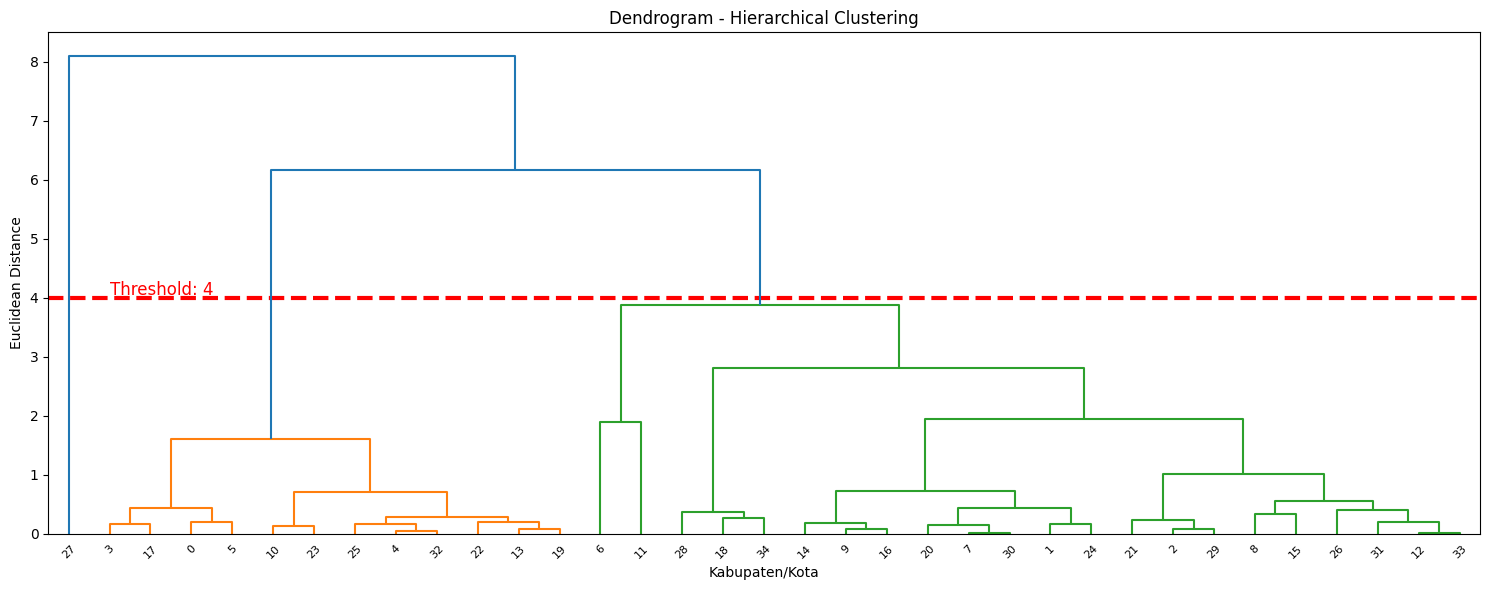

Silhouette Score: 0.4457
Davies-Bouldin Score: 0.4825


In [9]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load dataset
case_data = pd.read_csv("../../Dataset/data_normalized.csv")

# Fitur untuk clustering
X_scaled = case_data[['Jumlah_Murid_SMA', 'PDRB_harga_konstan']]

# Compute linkage matrix
linked = linkage(X_scaled, method='ward') 

# Plot dendrogram
plt.figure(figsize=(15, 6))
plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Kabupaten/Kota')
plt.ylabel('Euclidean Distance')

# Menambahkan garis horizontal sebagai threshold
threshold = 4 
plt.hlines(y=threshold, xmin=0, xmax=2000, colors='r', linestyles='--', lw=3)
plt.text(x=15, y=threshold + 0.05, s='Threshold: 4', fontsize=12, color='red')

# Dendrogram
dendrogram = sch.dendrogram(linked)

plt.tight_layout()
plt.show()

#  Menambahkan label cluster
num_clusters = 3  # jumlah klaster berdasarkan threshold
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Tambahkan label klaster ke data
case_data['Cluster_HC'] = cluster_labels

# Evaluasi model
silhouette = silhouette_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)

print("Silhouette Score:", round(silhouette, 4))
print("Davies-Bouldin Score:", round(db_score, 4))


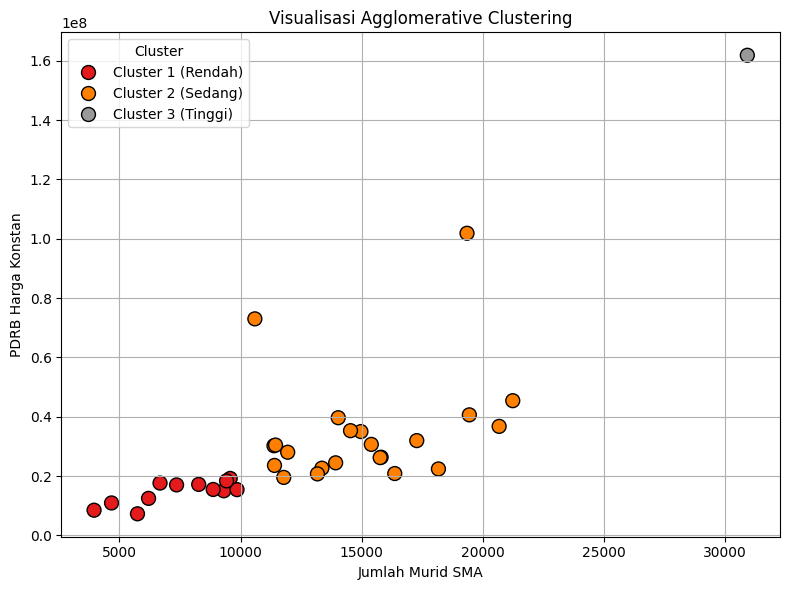

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.cluster import AgglomerativeClustering

# Buat model Agglomerative Clustering
agglo_model = AgglomerativeClustering(n_clusters=3)

# Fit model dan prediksi label klaster
agglo_labels = agglo_model.fit_predict(X_scaled)

# Tambahkan label asli ke dataframe
case_data['Cluster_AGG_raw'] = agglo_labels 

# Hitung rata-rata skor
cluster_means = {
    label: X_scaled[agglo_labels == label].mean().sum() 
    for label in np.unique(agglo_labels)
}

# Urutkan dari kecil ke besar
sorted_clusters = sorted(cluster_means.items(), key=lambda x: x[1])  
cluster_remap = {old: new + 1 for new, (old, _) in enumerate(sorted_clusters)}  

# Menerapkan remap
case_data['Cluster_AGG'] = case_data['Cluster_AGG_raw'].map(cluster_remap)
remapped_labels = case_data['Cluster_AGG'] - 1 

# Visualisasi
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_original['Jumlah_Murid_SMA'],
    X_original['PDRB_harga_konstan'],
    c=remapped_labels,
    cmap='Set1',
    s=100,
    edgecolor='k'
)

# Label sumbu
plt.xlabel('Jumlah Murid SMA')
plt.ylabel('PDRB Harga Konstan')
plt.title('Visualisasi Agglomerative Clustering')

# Legend urut berdasarkan cluster baru
cluster_descriptions = {1: 'Rendah', 2: 'Sedang', 3: 'Tinggi'}
legend_labels = sorted(case_data['Cluster_AGG'].unique())
patches = [
    Line2D([0], [0], marker='o', color='w',
           label=f'Cluster {label} ({cluster_descriptions[label]})',
           markerfacecolor=scatter.cmap(scatter.norm(label - 1)),
           markersize=10, markeredgecolor='k')
    for label in legend_labels
]
plt.legend(handles=patches, title="Cluster")

plt.grid(True)
plt.tight_layout()
plt.show()


## Visualisasi Klaster Agglomerative dalam Peta Interaktif

Hasil klasterisasi menggunakan algoritma **Agglomerative Clustering** (dengan jumlah klaster 3) pada data terstandarisasi. Setiap titik kabupaten/kota di Jawa Tengah divisualisasikan ke dalam peta interaktif **Folium**, dengan warna dan label berbeda sesuai hasil klaster yang telah di-*remap* berdasarkan rata-rata fitur.


In [11]:
import pandas as pd
import folium
import joblib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Load dataset
case_data = pd.read_csv("../../Dataset/data_normalized.csv")

# Load model Agglomerative
agglo_model = joblib.load('model/model_agglo_k3.pkl')

# Ambil fitur untuk klaster
X_scaled = case_data[['Jumlah_Murid_SMA', 'PDRB_harga_konstan']]

# Prediksi cluster
agglo_labels = agglo_model.fit_predict(X_scaled)

# Remap label
cluster_means = {
    label: X_scaled[agglo_labels == label].mean().sum()
    for label in np.unique(agglo_labels)
}
sorted_clusters = sorted(cluster_means.items(), key=lambda x: x[1])
cluster_remap = {old: new + 1 for new, (old, _) in enumerate(sorted_clusters)}

# Terapkan remap ke dataframe
case_data['Cluster_AGG'] = [cluster_remap[label] for label in agglo_labels]

# Warna untuk cluster
n_clusters = len(set(agglo_labels))
colormap = plt.get_cmap('Set1', n_clusters)
original_colors = [mcolors.to_hex(colormap(i)) for i in range(n_clusters)]

# Mapping warna berdasarkan cluster yang sudah diurutkan
cluster_colors = {i + 1: original_colors[i] for i in range(n_clusters)}

# Setup peta
map_center = [case_data['latitude'].mean(), case_data['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=8)

# Marker dengan warna dan label sesuai cluster yang baru
for idx, row in case_data.iterrows():
    cluster_number = row['Cluster_AGG']
    color = cluster_colors.get(cluster_number, 'gray')

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['kab_kota']} (Cluster {cluster_number})",
        icon=folium.DivIcon(html=f"""
            <div style="
                font-size: 12pt;
                color: white;
                background-color: {color};
                border-radius: 50%;
                width: 24px;
                height: 24px;
                text-align: center;
                line-height: 24px;
                border: 2px solid white;
            ">
                {cluster_number}
            </div>
        """)
    ).add_to(m)

# Simpan peta ke file HTML
m.save('../../Output/agglomerative_map.html')

m 


## Visualisasi Klaster Agglomerative pada Peta Wilayah Jawa Tengah

Hasil klasterisasi Agglomerative dengan 3 klaster berdasarkan fitur Jumlah Murid SMA dan PDRB Harga Konstan. Data klaster digabungkan dengan peta wilayah administratif Jawa Tengah menggunakan GeoPandas, lalu divisualisasikan dengan warna gradasi kuning untuk tiap klaster (Rendah, Sedang, Tinggi). Peta menampilkan lokasi titik kabupaten/kota dengan label nama.


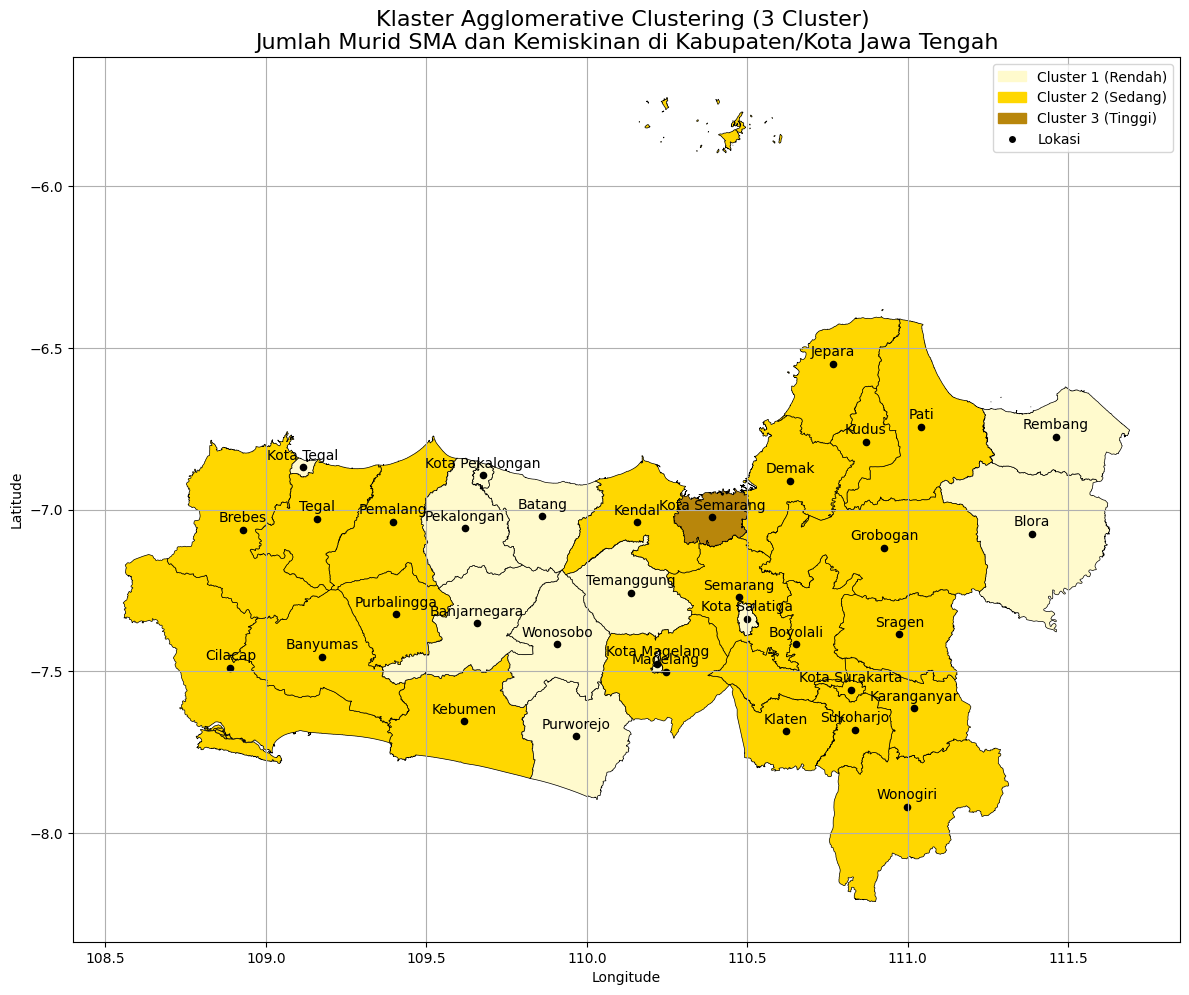

In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import joblib
import numpy as np

# Load data utama
case_data = pd.read_csv("../../Dataset/data_normalized.csv")
X_scaled = case_data[['Jumlah_Murid_SMA', 'PDRB_harga_konstan']]

# Load model Agglomerative Clustering
agglo_model = joblib.load('model/model_agglo_k3.pkl')

# Prediksi cluster
agglo_labels = agglo_model.fit_predict(X_scaled)

# Remap label
cluster_means = {
    label: X_scaled[agglo_labels == label].mean().sum()
    for label in np.unique(agglo_labels)
}
sorted_clusters = sorted(cluster_means.items(), key=lambda x: x[1])
cluster_remap = {old: new + 1 for new, (old, _) in enumerate(sorted_clusters)}

# Terapkan remap
case_data['Cluster_AGG'] = [cluster_remap[label] for label in agglo_labels]

# Load shapefile
gdf = gpd.read_file("../../Dataset/Lokasi/KAB_KOTA_JATENG.shp")

# Merge data cluster ke shapefile
merged = gdf.merge(case_data, on="kab_kota")

# Definisikan warna sesuai urutan klaster 
colors_list = ['#FFFACD', '#FFD700', '#B8860B']  # Kuning muda → gelap
cmap = LinearSegmentedColormap.from_list("YellowShades", colors_list)
num_clusters = 3
colors = [cmap(i / (num_clusters - 1)) for i in range(num_clusters)]
cluster_colors = {i + 1: colors[i] for i in range(num_clusters)}

# Menambahkan warna ke data merged
merged['color'] = merged['Cluster_AGG'].map(cluster_colors)

# Legend patch dengan keterangan Rendah, Sedang, Tinggi
cluster_labels = {1: 'Rendah', 2: 'Sedang', 3: 'Tinggi'}
patches = [
    mpatches.Patch(color=cluster_colors[i], label=f'Cluster {i} ({cluster_labels[i]})')
    for i in cluster_colors
]

# Plot peta
fig, ax = plt.subplots(figsize=(12, 10))
merged.plot(ax=ax, color=merged['color'], edgecolor='black', linewidth=0.5)

# Plot titik lokasi
if 'longitude' in merged.columns and 'latitude' in merged.columns:
    ax.scatter(
        merged['longitude'],
        merged['latitude'],
        color='black',
        s=20,
        label='Lokasi'
    )
    # Tambahkan label kab/kota
    for i, row in merged.iterrows():
        ax.text(row['longitude'], row['latitude'] + 0.015, row['kab_kota'], fontsize=10, ha='center', va='bottom')

# Tambahkan legenda
plt.legend(handles=patches + [plt.Line2D([0], [0], marker='o', color='w', label='Lokasi',
                                         markerfacecolor='black', markersize=6)], loc='best')

plt.title("Klaster Agglomerative Clustering (3 Cluster) \nJumlah Murid SMA dan Kemiskinan di Kabupaten/Kota Jawa Tengah", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()

plt.savefig('../../Output/Peta_klaster_agglomerative.png', format='png', dpi=600)

plt.show()
